In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import time

## Create the evaluation function

In [167]:
# Function for feature selection version 1
def feature_selection(X, Y):
    f, p = f_classif(X, Y)
    corr_df = pd.DataFrame({'features': X.columns, 'f_val': f, 'p_val': p})
    # using the 3 level significance test 
    # (***: p_val < 0.001, **: p_val < 0.01, *: p_val < 0.05)
    # we will select the features with p_val < 0.05
    p_tr = 0.001
    relevant_features = corr_df.loc[corr_df['p_val'] < p_tr, "features"].tolist()
    # print(f"There are {len(relevant_features)} relevant features and they are: {relevant_features}")
    
    return relevant_features

I created a feature selection function that includes different selection methods:

In [168]:
# Function for feature selection version 2
def select_features(X, y, method, corr_threshold=0.5):
    
    if method is None:
        return X.columns
        
    # Feature selection using chi-squared
    elif method == 'p-value':
        # Remove constant features
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        p_values = []
        for feature in X.columns:
            f, p = chi2(X[[feature]], y)
            p_values.append(p)

        p_values = np.array(p_values).reshape(-1)
        p_values = pd.Series(p_values, index=X.columns).sort_values()
        selected_features = p_values[p_values < 0.05].index
    
    # Feature selection using VarianceThreshold
    elif method == 'variance':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        var_thr = VarianceThreshold(threshold=0.25)
        var_thr.fit(X)
        selected_features = X.columns[var_thr.get_support()]  
    
    # Feature selection using Pearson correlation
    elif method == 'correlation':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        corr = X.corr()
        col_corr = set()

        corr_matrix = np.abs(corr.values)

        n = corr_matrix.shape[0]

        for i in range(n):
            for j in range(i):
                if corr_matrix[i, j] > corr_threshold:
                    colname = X.columns[i]
                    col_corr.add(colname)

        selected_features = [col for col in X.columns if col not in col_corr]

    # More methods to be added 
                
    return selected_features

I created a scaling function which includes different scaling methods:

In [169]:
# Function for scaling the data
def scale(X_train, X_test, method):
    
    if method is None:
        return X_train, X_test

    # Scaling using StandardScaler 
    elif method == 'standard':
        scaler = StandardScaler().fit(X_train)

    # Scaling using MinMaxScaler
    elif method == 'minmax':
        scaler = MinMaxScaler().fit(X_train)

    # Scaling using RobustScaler
    elif method == 'robust':
        scaler = RobustScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
                
    return X_train_scaled, X_test_scaled

Time measurements have been added

In [170]:
def evaluate_model(X, Y, feature_selection, scaling, classifier, splitting, folds=5):
    if splitting == "cv":
        kf = KFold(n_splits=folds, shuffle=True, random_state=18)
        metric_results = {}
        #do the KFold cross validation
        for train_index, test_index in kf.split(X,Y):
            # split the data into train and test for this fold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]   
            
            # preprocess the data
            # feature selection
            preprocess_start_time = time.time()
            rel_features = select_features(X_train, y_train, feature_selection)
            n_features_orig = X_train.shape[1]
            n_features = len(rel_features)
            # scaling the data
            X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)
            preprocess_end_time = time.time()
            preprocess_time = preprocess_end_time - preprocess_start_time
                
            # train and evaluate the model
            clf = classifier
            train_start_time = time.time()
            clf.fit(X_train_preprocessed, y_train)
            train_end_time = time.time()
            training_time = train_end_time - train_start_time
            
            pred_start_time = time.time()
            Y_pred_fold = clf.predict(X_test_preprocessed)
            pred_end_time = time.time()
            prediction_time = pred_end_time - pred_start_time
                
            # calculate the accuracy, precision, recall and f1 score per fold
            accuracy = metrics.accuracy_score(y_test, Y_pred_fold)
            precision = metrics.precision_score(y_test, Y_pred_fold, average='weighted')
            recall = metrics.recall_score(y_test, Y_pred_fold, average='weighted')
            f1 = metrics.f1_score(y_test, Y_pred_fold, average='weighted')

            # add the scores to the dict
            metric_results.setdefault('accuracy', []).append(accuracy)
            metric_results.setdefault('precision', []).append(precision)
            metric_results.setdefault('recall', []).append(recall)
            metric_results.setdefault('f1', []).append(f1)
            metric_results.setdefault('training_time', []).append(training_time)
            metric_results.setdefault('prediction_time', []).append(prediction_time)
            metric_results.setdefault('preprocess_time', []).append(preprocess_time)
            
            
        # Calculate the mean of the metrics over all folds
        accuracy_mean = np.mean(metric_results['accuracy'])
        precision_mean = np.mean(metric_results['precision'])
        recall_mean = np.mean(metric_results['recall'])
        f1_mean = np.mean(metric_results['f1'])
        training_time_mean = np.mean(metric_results['training_time'])
        prediction_time_mean = np.mean(metric_results['prediction_time'])
        preprocess_time_mean = np.mean(metric_results['preprocess_time'])
        
        # Calculate the standard deviation of f1
        f1_std = np.std(metric_results['f1'])

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy_mean, 'precision': precision_mean, 'recall': recall_mean, 'f1': f1_mean, 'f1_std': f1_std, 'preprocess_time': preprocess_time_mean,'training_time': training_time_mean, 'prediction_time': prediction_time_mean}

    elif splitting == "holdout":
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)
        
        # preprocess the data
        # feature selection
        preprocess_start_time = time.time()
        rel_features = select_features(X_train, y_train, feature_selection)
        n_features_orig = X_train.shape[1]
        n_features = len(rel_features)
        # scaling the data
        X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)
        preprocess_end_time = time.time()
        preprocess_time = preprocess_end_time - preprocess_start_time


        

        # train and evaluate the model
        clf = classifier
        train_start_time = time.time()
        clf.fit(X_train_preprocessed, y_train)
        train_end_time = time.time()
        training_time = train_end_time - train_start_time
        
        pred_start_time = time.time()
        Y_pred = clf.predict(X_test_preprocessed)
        pred_end_time = time.time()
        prediction_time = pred_end_time - pred_start_time

        # calculate the accuracy, precision, recall and f1 score per fold
        accuracy = metrics.accuracy_score(y_test, Y_pred)
        precision = metrics.precision_score(y_test, Y_pred, average='weighted')
        recall = metrics.recall_score(y_test, Y_pred, average='weighted')
        f1 = metrics.f1_score(y_test, Y_pred, average='weighted')

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'preprocess_time': preprocess_time,'training_time': training_time, 'prediction_time': prediction_time}
    

### Smote function for balancing class column

For those datasets that have an imbalanced response variable the smote method can be implimented to compensate for the class imbalance in the data

In [171]:
def apply_smote(df, target_column, k_neighbors=4, random_state=321):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    return X_resampled, y_resampled

## Load the data



### Congressional voting
An iterativ imputation has been already done on the data.

In [172]:
test_df = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
test_df.set_index('ID', inplace=True)
test_df_X = test_df.drop(columns=["class"])
test_df_Y = test_df["class"]

## Evaluation

The **evaluate_model** function takes:
* the input feature (*X*),
* the dependent variable (*Y*)
* the preprocessing method as a string:
    * the so far implemented possible options can be found in the *preprocess_options* list. Here *else* is implemented as the *StandardScaler()*, however it could be combined with additional feature selection to achieve a better result.
* classifier as a function:
    * so far the only tried one is *SVC(C=3, kernel='sigmoid')*
* folds to define the number of  folds. The default value is 5.

In [173]:
#preprocess_options = ["none", "featureselection", "else"]

The changed evaluate_model function is the following:
* takes the input feature and the dependent variable
* splits the data into train and test set
* preprocesses the data
    * feature selection
    * scaling 
* trains the classifier on the train set

In [174]:
evaluate_model(test_df_X, test_df_Y, "p-value", "robust", SVC(C=3, kernel='sigmoid'), splitting="cv")

{'classifier': 'SVC',
 'splitting': 'cv',
 'feature_selection': 'p-value',
 'scaling': 'robust',
 'n_features_orig': 16,
 'n_features': 13,
 'accuracy': 0.9447145877378436,
 'precision': 0.9458858894825214,
 'recall': 0.9447145877378436,
 'f1': 0.9446694623832087,
 'f1_std': 0.023332176291890664,
 'preprocess_time': 0.14551119804382323,
 'training_time': 0.0026483535766601562,
 'prediction_time': 0.0005918025970458984}

## Experimeting a bit

Loading the datasets

In [175]:
bank_marketing = pd.read_csv("./preprocessed-datasets/bank_marketing_prepro.csv")
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     41188 non-null  int64  
 1   age                            41188 non-null  int64  
 2   default                        41188 non-null  float64
 3   housing                        41188 non-null  float64
 4   loan                           41188 non-null  float64
 5   campaign                       41188 non-null  int64  
 6   pdays                          41188 non-null  int64  
 7   previous                       41188 non-null  int64  
 8   emp.var.rate                   41188 non-null  float64
 9   cons.price.idx                 41188 non-null  float64
 10  cons.conf.idx                  41188 non-null  float64
 11  euribor3m                      41188 non-null  float64
 12  nr.employed                    41188 non-null 

In [176]:
wine_quality = pd.read_csv("./preprocessed-datasets/wine_quality_prepro.csv")
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  class                 6497 non-null   int64  
 13  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


In [177]:
congression_voting = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
congression_voting.set_index('ID', inplace=True)
congression_voting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 140 to 324
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   handicapped-infants                     217 non-null    float64
 1   water-project-cost-sharing              217 non-null    float64
 2   adoption-of-the-budget-resolution       217 non-null    float64
 3   physician-fee-freeze                    217 non-null    float64
 4   el-salvador-aid                         217 non-null    float64
 5   religious-groups-in-schools             217 non-null    float64
 6   anti-satellite-test-ban                 217 non-null    float64
 7   aid-to-nicaraguan-contras               217 non-null    float64
 8   mx-missile                              217 non-null    float64
 9   immigration                             217 non-null    float64
 10  synfuels-crporation-cutback             217 non-null    floa

In [178]:
reviews = pd.read_csv("./preprocessed-datasets/Review_prepro.csv")
reviews.set_index('ID', inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Columns: 10001 entries, V1 to class
dtypes: int64(10000), object(1)
memory usage: 57.2+ MB


In [180]:
datasets = {
    #'wine_quality': wine_quality,
    'reviews': reviews,
    #'congression_voting': congression_voting,
    #'bank_marketing': bank_marketing
}

feature_selection_methods = [None, 'p-value'] # , 'variance' , 'correlation']
scaling_methods = [None, 'standard'] #, 'robust', 'minmax']
classifiers = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier()] # LinearSVC(), SVC(C=3, kernel='sigmoid')] #, GaussianNB()]
splitting_methods = ['holdout', 'cv']

results = []

for dataset_name, dataset in datasets.items():
    for feature_selection_method in feature_selection_methods:
        for scaling_method in scaling_methods:
            for classifier in classifiers:
                for splitting_method in splitting_methods: # ,'cv']:
                    if dataset_name == 'wine_quality' or dataset_name == 'bank_marketing':
                        target_column = 'class'
                        X,Y = apply_smote(dataset,target_column)
                    else:
                        X = dataset.drop(columns=["class"])
                        Y = dataset["class"]
                    evaluation_result = evaluate_model(X, Y, feature_selection_method, scaling_method, classifier, splitting_method)
                    print(f"Time taken for {dataset_name}, {feature_selection_method}, {scaling_method}, {classifier.__class__.__name__}, {splitting_method}: preprocessing time: {evaluation_result['preprocess_time']} seconds, training time: {evaluation_result['training_time']} seconds")
                    results.append({'dataset': dataset_name, 'result': evaluation_result})



/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, None, None, KNeighborsClassifier, holdout: preprocessing time: 0.18355202674865723 seconds, training time: 0.588871955871582 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, None, None, KNeighborsClassifier, cv: preprocessing time: 0.033992671966552736 seconds, training time: 0.18857893943786622 seconds
Time taken for reviews, None, None, DecisionTreeClassifier, holdout: preprocessing time: 0.04437518119812012 seconds, training time: 1.6125969886779785 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, None, None, DecisionTreeClassifier, cv: preprocessing time: 0.029095983505249022 seconds, training time: 1.6863929271697997 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, None, None, RandomForestClassifier, holdout: preprocessing time: 0.04990577697753906 seconds, training time: 2.715338945388794 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, None, None, RandomForestClassifier, cv: preprocessing time: 0.031125783920288086 seconds, training time: 1.7106135845184327 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, None, standard, KNeighborsClassifier, holdout: preprocessing time: 0.506777286529541 seconds, training time: 0.048973798751831055 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, None, standard, KNeighborsClassifier, cv: preprocessing time: 0.5561811923980713 seconds, training time: 0.05706524848937988 seconds
Time taken for reviews, None, standard, DecisionTreeClassifier, holdout: preprocessing time: 0.48235082626342773 seconds, training time: 1.3118081092834473 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, None, standard, DecisionTreeClassifier, cv: preprocessing time: 0.47115440368652345 seconds, training time: 1.4088537216186523 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, None, standard, RandomForestClassifier, holdout: preprocessing time: 0.4669358730316162 seconds, training time: 1.6972157955169678 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, None, standard, RandomForestClassifier, cv: preprocessing time: 0.4898835182189941 seconds, training time: 1.6188488006591797 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, None, KNeighborsClassifier, holdout: preprocessing time: 71.8312828540802 seconds, training time: 0.09829497337341309 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, p-value, None, KNeighborsClassifier, cv: preprocessing time: 84.95424556732178 seconds, training time: 0.1096503734588623 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, None, DecisionTreeClassifier, holdout: preprocessing time: 77.20761322975159 seconds, training time: 1.002474069595337 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, p-value, None, DecisionTreeClassifier, cv: preprocessing time: 70.370490026474 seconds, training time: 1.0828888893127442 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, None, RandomForestClassifier, holdout: preprocessing time: 106.38257312774658 seconds, training time: 2.0690789222717285 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, p-value, None, RandomForestClassifier, cv: preprocessing time: 75.00950498580933 seconds, training time: 1.3805222034454345 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, standard, KNeighborsClassifier, holdout: preprocessing time: 64.42492008209229 seconds, training time: 0.0280759334564209 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, p-value, standard, KNeighborsClassifier, cv: preprocessing time: 73.35817461013794 seconds, training time: 0.036687469482421874 seconds
Time taken for reviews, p-value, standard, DecisionTreeClassifier, holdout: preprocessing time: 69.1601037979126 seconds, training time: 0.9591090679168701 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, p-value, standard, DecisionTreeClassifier, cv: preprocessing time: 71.63160243034363 seconds, training time: 1.0727156162261964 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, standard, RandomForestClassifier, holdout: preprocessing time: 72.79871726036072 seconds, training time: 1.2675161361694336 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rebekaangyal/Library/Python/3.9/

Time taken for reviews, p-value, standard, RandomForestClassifier, cv: preprocessing time: 74.39846315383912 seconds, training time: 1.4346036911010742 seconds


/Users/rebekaangyal/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [186]:
df = pd.DataFrame(results)
results_df = pd.json_normalize(df['result'])
results_df.insert(0, 'dataset', df['dataset'])
#results_df.to_csv('./data/results_one_half_reviews.csv', index=False)
results_df

,dataset,classifier,splitting,feature_selection,scaling,n_features_orig,n_features,accuracy,precision,recall,f1,preprocess_time,training_time,prediction_time,f1_std
0,reviews,KNeighborsClassifier,holdout,None,None,10000,10000,0.168889,0.226259,0.168889,0.167173,0.183552,0.588872,0.371689,NaN
1,reviews,KNeighborsClassifier,cv,None,None,10000,10000,0.190667,0.229280,0.190667,0.177675,0.033993,0.188579,0.299308,0.042618
2,reviews,DecisionTreeClassifier,holdout,None,None,10000,10000,0.333333,0.390857,0.333333,0.340607,0.044375,1.612597,0.094909,NaN
3,reviews,DecisionTreeClassifier,cv,None,None,10000,10000,0.312000,0.370688,0.312000,0.312211,0.029096,1.686393,0.094763,0.048509
4,reviews,RandomForestClassifier,holdout,None,None,10000,10000,0.484444,0.592447,0.484444,0.481131,0.049906,2.715339,0.146309,NaN
5,reviews,RandomForestClassifier,cv,None,None,10000,10000,0.529333,0.595120,0.529333,0.518244,0.031126,1.710614,0.121008,0.053394
6,reviews,KNeighborsClassifier,holdout,None,standard,10000,10000,0.062222,0.082339,0.062222,0.043111,0.506777,0.048974,0.105852,NaN
7,reviews,KNeighborsClassifier,cv,None,standard,10000,10000,0.036000,0.034935,0.036000,0.017145,0.556181,0.057065,0.073821,0.012510
8,reviews,DecisionTreeClassifier,holdout,None,standard,10000,10000,0.342222,0.388153,0.342222,0.341065,0.482351,1.311808,0.005961,NaN
9,reviews,DecisionTreeClassifier,cv,None,standard,10000,10000,0.321333,0.363486,0.321333,0.317793,0.471154,1.408854,0.006259,0.051515


In [27]:
# in case the pipeline is not run separately
#results_df_old = pd.read_csv('./data/results_wo_reviews.csv')
#results_df = pd.concat([results_df_old, results_df])
#results_df.to_csv('./data/results.csv', index=False)
results_df.fillna("no_preprocessing", inplace=True)

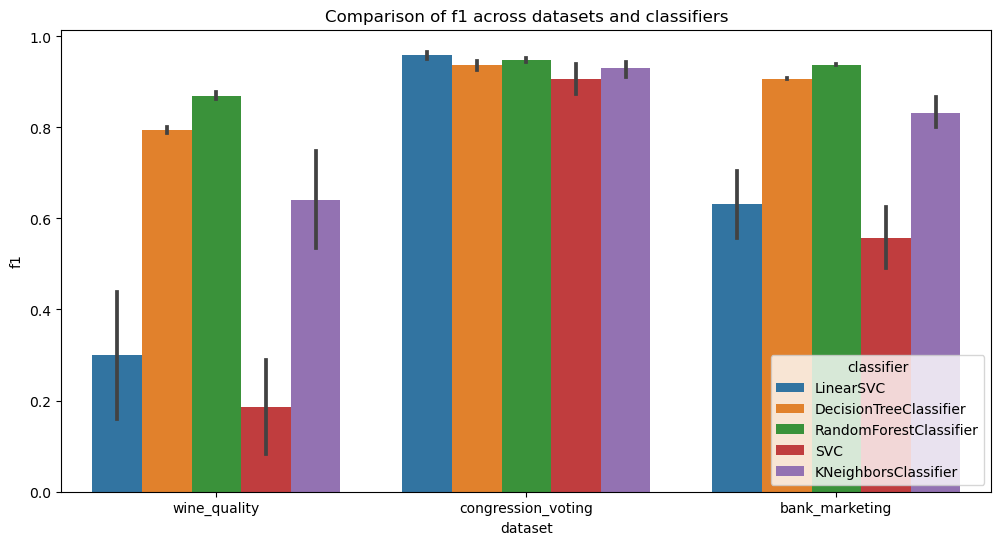

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='classifier', data=results_df)
plt.title('Comparison of f1 across datasets and classifiers')
plt.show()

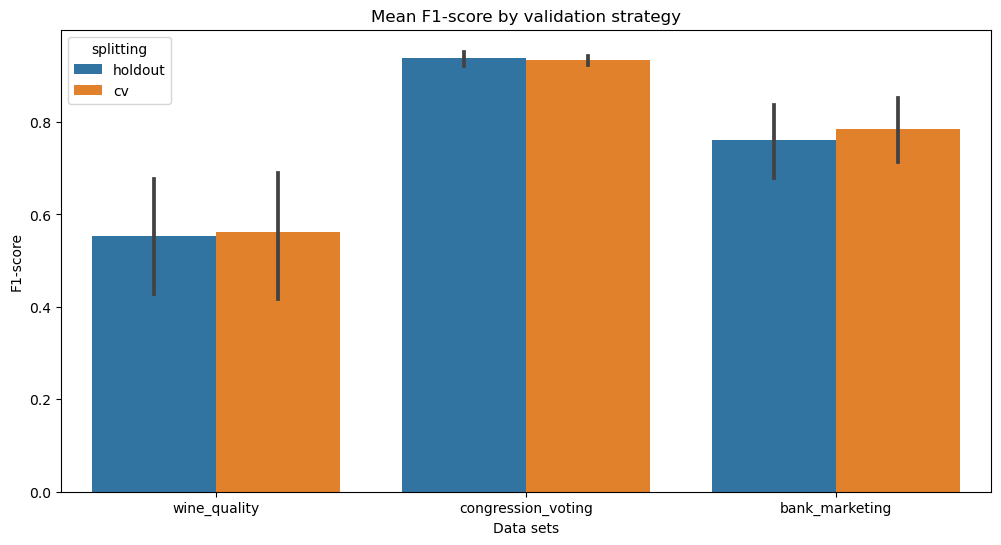

In [29]:
#plot f1-score across datasets for each classifier, cv vs holdout
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='splitting', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

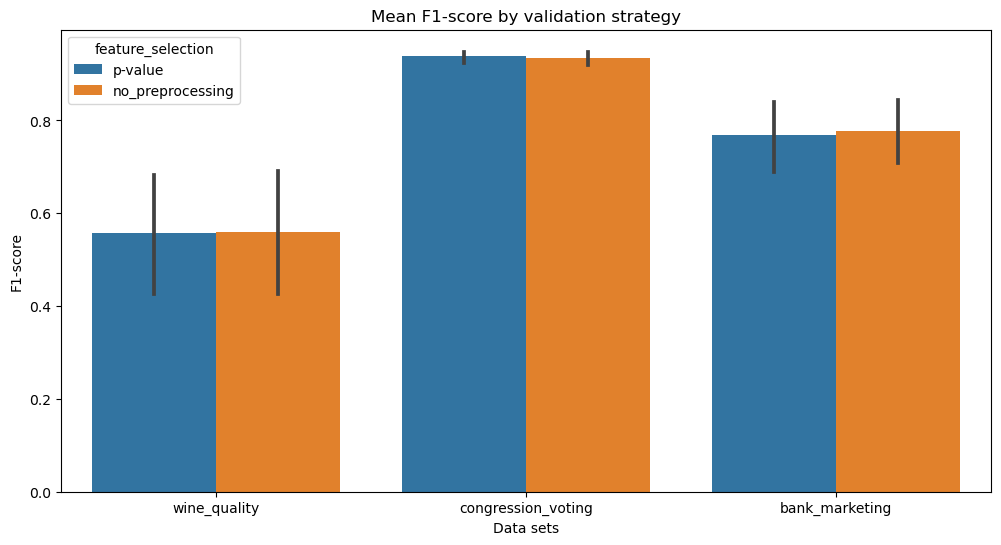

In [30]:
# data.groupby(['dataset', 'Spliting'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='feature_selection', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

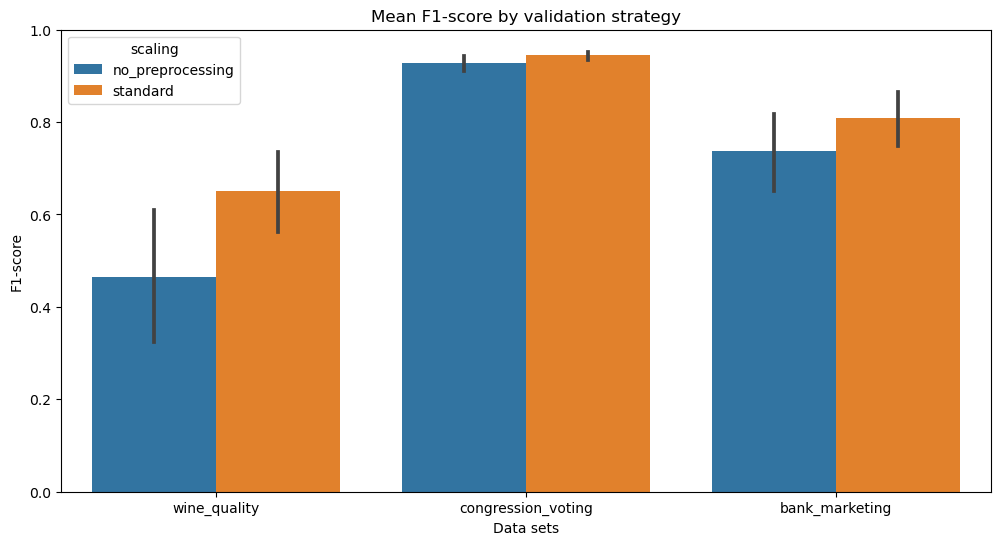

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='scaling', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

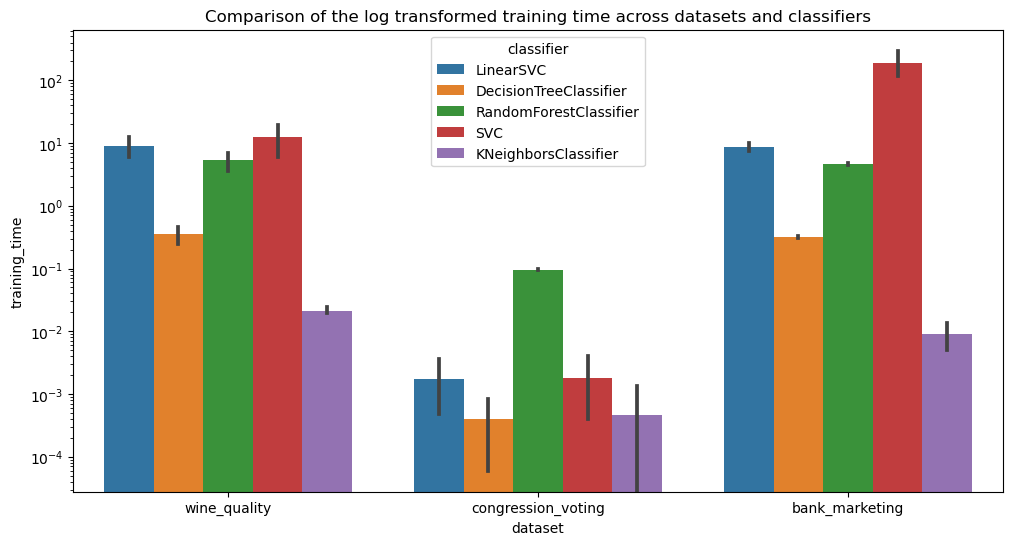

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='training_time', hue='classifier', data=results_df, log=True)
plt.title('Comparison of the log transformed training time across datasets and classifiers')
plt.show()